# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

In [ ]:
# !unset http_proxy
# !unset https_proxy
# !module load ollama/0.7.0-img 
# !export OLLAMA_MODELS=/project/GCRB/Hon_lab/s440862/courses/se/MODULE_3_MATERIALS/ollama/models
# !ollama serve &
# !${APP_IMAGE} run qwen3:4b
# !${APP_IMAGE} show qwen3:4b

In [1]:
!bash /project/GCRB/Hon_lab/s440862/courses/se/MODULE_3_MATERIALS/mod3/run_ollama.sh

	To start Ollama server, run 'ollama serve &'
	To access to the API server run following command.
	 curl --noproxy '*' http://localhost:11434/api/generate -d '{ "model": "llama2", "prompt": "Why is the sky blue", "stream": false }'
	
	Known issues:
		Use api commands with curl, don't use ollama commands directly. Contact BioHPC to install new models.


## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [16]:
# 1.1 Place imports here
from typing import List, Optional

from collections import defaultdict
from dataclasses import dataclass
import json
import pandas as pd
from tqdm import tqdm
import ollama
import os, sys
import seaborn as sns
from matplotlib import pyplot as plt

os.chdir('/project/GCRB/Hon_lab/s440862/courses/se/MODULE_3_MATERIALS/mod3')
os.environ['NO_PROXY'] ="*"

## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [17]:
# 2.1 Data Configuration
data_path = 'data/geneturing.json'
DATASET_NAME = 'geneturing'

In [18]:
# 2.2 Model Configuration
OLLAMA_BASE_URL = "http://localhost:11434"
OLLAMA_MODEL_NAME = "qwen3:4b" 
RESULT_SAVE_PATH = f'output/{DATASET_NAME}_{OLLAMA_MODEL_NAME}.csv'
OUTPUT_DIR = 'output/'

In [19]:
# 2.3 Evaluation and Logging Configuration

## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [20]:
# 3.1 Load the JSON file
with open(data_path, 'rb') as f:
    data = json.load(f)
# Load the data here

# Build the TASKS variable here

TASKS = set(data.keys()) 

In [21]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columns in the table above
rows = []
for task_name, questions_answers in tqdm(data.items()):
    for question, answer in questions_answers.items():
        rows.append({
            "task": task_name,
            "question": question,
            "answer": answer
        })

100%|██████████| 9/9 [00:00<00:00, 38756.40it/s]


In [22]:
df = pd.DataFrame(rows)
df['id'] = df.index

## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

In [23]:
# 4.1 Setting up the large language model Ollama model client

OllamaClient = ollama.Client(host=OLLAMA_BASE_URL)


### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [24]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_message = [
    {
        "role": "system",
        "content": f"Hello. You are an expertise in bioinformatics, and your job now is to use the NCBI Web APIs to give accurate and neat answers to genomic questions in aspects of {list(data.keys())}. For example, if I ask 'What is the official gene symbol of LMP10?', your answer should be: 'Answer: PSMB10'."
    }
]

### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [25]:
# 4.3 Appending the few-shot examples to the `messages` list
example_messages = [
    {
        "role": "user",
        "content": "Question: What is the official gene symbol of LMP10?"
    },
    {
        "role": "assistant",
        "content": "Answer: PSMB10"
    },
    {
        "role": "user",
        "content": "Question: Which gene is SNP rs1217074595 associated with?"
    },
    {
        "role": "assistant",
        "content": "Answer: LINC01270"
    },
    {
        "role": "user",
        "content": "Question: What are genes related to Meesmann corneal dystrophy?"
    },
    {
        "role": "assistant",
        "content": "Answer: KRT12, KRT3"
    },
    {
        "role": "user",
        "content": "Question: Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT"
    },
    {
        "role": "assistant",
        "content": "Answer: chr15:91950805-91950932"
    },
]

### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [26]:
# 4.4 Implement THE model function
def query_model(
    client: ollama.Client, 
    system_message: dict, 
    few_shot_examples: List[dict], 
    user_query: str,
    model_name: str = OLLAMA_MODEL_NAME,
) -> str:
    """Implement ME"""
    messages = []
    messages.extend(system_message)
    messages.extend(few_shot_examples)
    messages.append({"role": "user", "content": f"Question: {user_query}"})

    try:
        response = client.chat(model=model_name, messages=messages)
        content = response['message']['content'].strip()
        if "Answer:" in content:
            return content.split("Answer:")[-1].strip()
        return content
    except Exception as e:
        print(f"Error querying model: {e}")
        return None


## 5. Metrics

The GeneTuring dataset has several task specific evaluation metrics that are variations on exact match depending on the expected cardinality of the output.

Please inspect `evaluate.py` from the GeneGPT repository to find the metric functions and implement them here.

Original functions: [evaluate.py](https://github.com/ncbi/GeneGPT/blob/main/evaluate.py)

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [27]:
# 5.1 Implement metrics

def exact_match(pred: str, true: str) -> float:
    return int(pred == true)

def gene_disease_association(pred: list, true: list) -> float:
    pred_set = set(pred.split(', '))
    true_set = set(true.split(', '))
    if not true_set:
        return 1 if not pred_set else 0
    return len(pred_set.intersection(true_set)) / len(true_set)

def disease_gene_location(pred: list, true: list) -> float:
    pred_set = set(pred.split(', '))
    true_set = set(true.split(', '))
    if not true_set:
        return 1 if not pred_set else 0
    return len(pred_set.intersection(true_set)) / len(true_set)
    
def human_genome_dna_alignment(pred: str, true: str) -> float:
    if pred == true:
        return 1.0
    elif true.split(':')[0] == pred.split(':')[0]: 
        return 0.5
    return 0.0

metric_task_map = defaultdict(lambda: exact_match, {
    "gene_disease_association": gene_disease_association,
    "disease_gene_location": disease_gene_location,
    "human_genome_dna_alignment": human_genome_dna_alignment
})


Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [28]:
# 5.2 Implement the answer mapping function

def get_answer(answer: str, task: str) -> str:

	mapper = {'Caenorhabditis elegans': 'worm',
			  'Homo sapiens': 'human',
			  'Danio rerio': 'zebrafish',
			  'Mus musculus': 'mouse',
			  'Saccharomyces cerevisiae': 'yeast',
			  'Rattus norvegicus': 'rat',
			  'Gallus gallus': 'chicken'}

	if task == 'SNP location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene disease association':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Disease gene location':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Protein-coding genes':
		answer = answer.strip().replace('Answer: ', '')
		if answer == 'Yes':
			answer = 'TRUE'
		elif answer == 'No':
			answer = 'NA'

	elif task == 'Multi-species DNA aligment':
		answer = answer.strip().replace('Answer: ', '')
		answer = mapper.get(answer, answer)

	else:
		answer = answer.strip().replace('Answer: ', '')
	
	return answer

## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [29]:
# 6.1 Set up data structures for results

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    raw_prediction: Optional[str]
    processed_prediction: Optional[str]
    score: Optional[float]
    success: bool

def save_results(results: List[Result], results_csv_filename: str) -> None:
    results_df = pd.DataFrame([r.__dict__ for r in results])
    results_df.to_csv(results_csv_filename, index=False)
    print(f"Results saved.")

In [ ]:
# 6.2 Loop over the dataset with a progress bar

# * Do not forget to add the results to our Result list, both successful and failed predictions
# * API calls will not always work, so make sure we capture the exceptions from failed calls
#    and add them to the Result list with a `status=False`
results: List[Result] = []
for index, row in tqdm(df.iterrows(), total=len(df), desc=f"Evaluating {DATASET_NAME}"):
    example_id = row['id']
    task = row['task']
    question = row['question']
    true_answer = str(row['answer'])

    raw_prediction = None
    processed_prediction = None
    score = None
    success = False

    try:
        raw_prediction = query_model(OllamaClient, system_message, example_messages, question)
        if raw_prediction is not None:
            processed_prediction = get_answer(raw_prediction, task)
            metric_func = metric_task_map[task]

            if task in ["Gene disease association", "Disease gene location"]:
                score = metric_func(pred=processed_prediction, true=get_answer(true_answer, task))
            else:
                score = metric_func(pred=processed_prediction, true=true_answer)
            success = True
        else:
            success = False
    except Exception as e:
        print(f"Error processing example {example_id}: {e}")
        success = False

    results.append(Result(
        id=example_id,
        task=task,
        question=question,
        answer=true_answer,
        raw_prediction=raw_prediction,
        processed_prediction=processed_prediction,
        score=score,
        success=success
    ))

In [ ]:
# 6.3 Save the results
save_results(results, RESULT_SAVE_PATH)

Results saved.


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [34]:
# 7.1 Calculate the fraction of successful predictions
results = pd.read_csv(RESULT_SAVE_PATH, index_col=0)
success = results[results['success']==True]
print(f'{len(success)/len(results)*100}% predictions were successfully runned.')

100.0% predictions were successfully runned.


Now let's calculate both the overall score as well as the score by task.

In [53]:
# 7.2 Calculate the overall score and the score by task
mean_total = round(success['score'].mean(), 3)
print(f'The average score for all successful cases are: {mean_total}.')

df_avg_score_per_task = success.groupby(by='task')['score'].mean()
print('For individual tasks:')
print(df_avg_score_per_task)

The average score for all successful cases are: 0.042.
For individual tasks:
task
Gene SNP association          0.02
Gene alias                    0.10
Gene disease association      0.08
Gene location                 0.04
Gene name conversion          0.00
Human genome DNA aligment     0.02
Multi-species DNA aligment    0.06
Protein-coding genes          0.00
SNP location                  0.06
Name: score, dtype: float64


Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

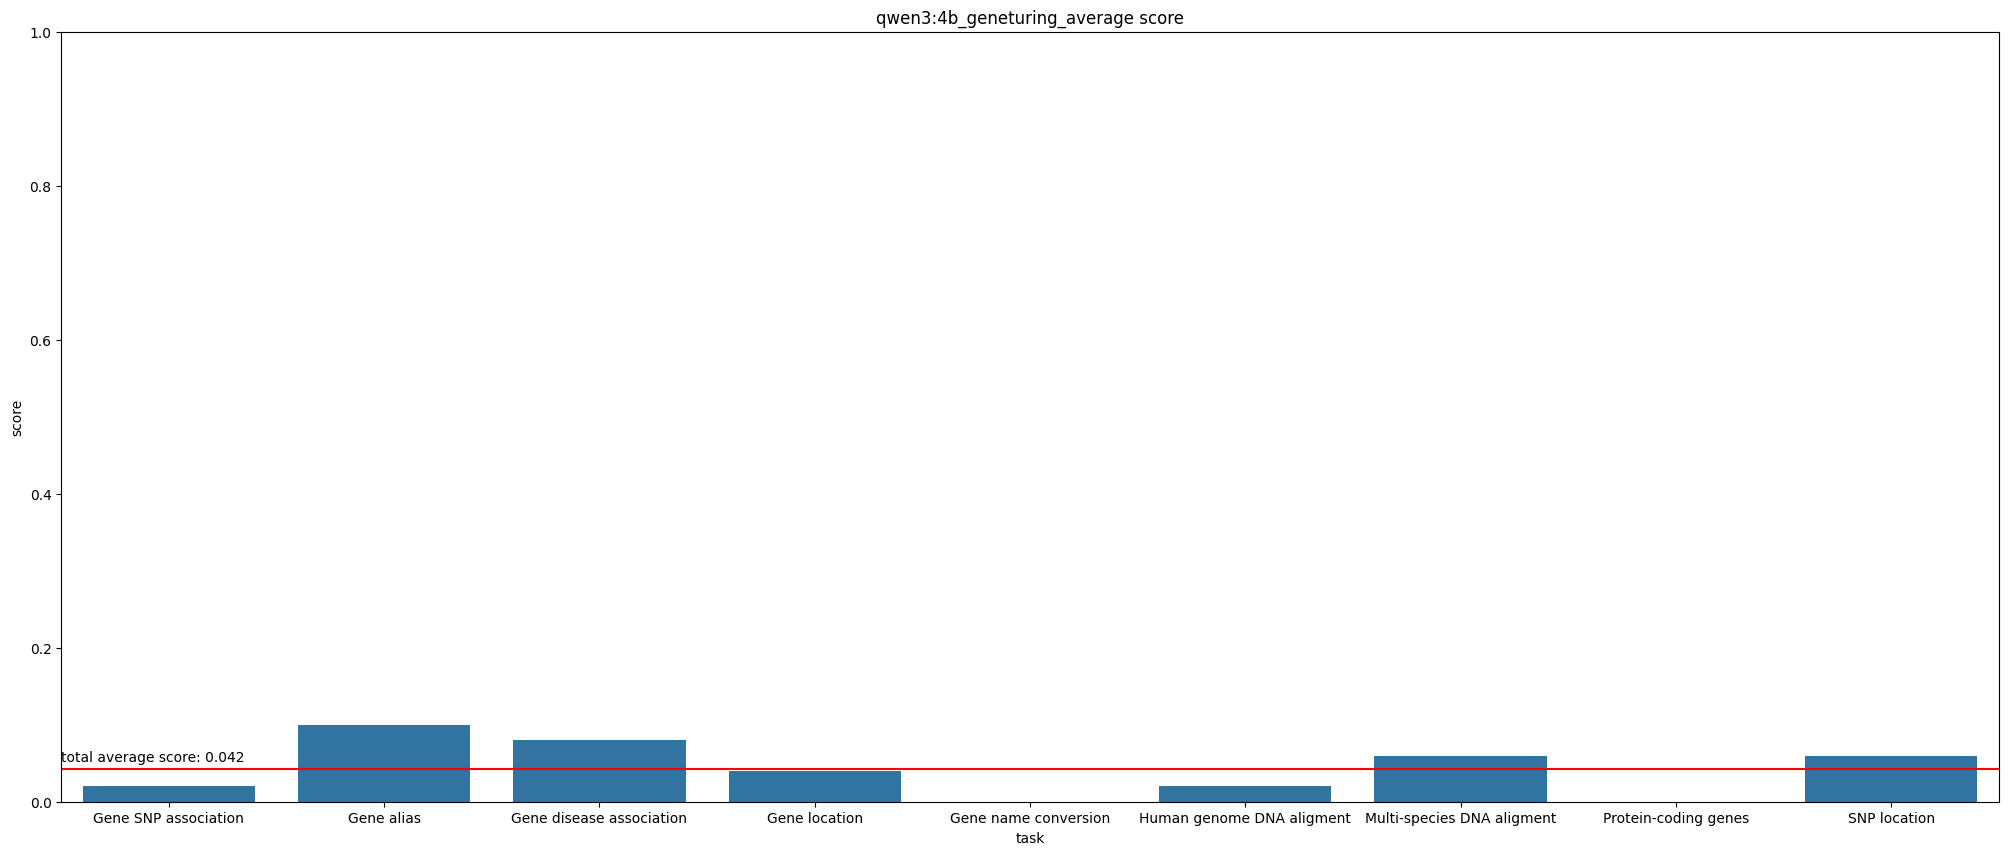

In [69]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score

plt.figure(figsize=(25, 10))
sns.barplot(df_avg_score_per_task)
plt.ylim((0,1))
plt.axhline(y=mean_total, c='red')
plt.text(y=mean_total+0.01, s=f'total average score: {mean_total}', x=-0.5)
plt.title(f'{OLLAMA_MODEL_NAME}_{DATASET_NAME}_average score')
plt.savefig(os.path.join(OUTPUT_DIR, f'{OLLAMA_MODEL_NAME}_{DATASET_NAME}_average score.png'))